In [3]:
# Base packages
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import os,re, nltk, spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

# Path
folders = './final/'
file_url = folders + 'lematize_corpus_vec.csv'

model_folders = './models/'
dest_model_file_a = model_folders + 'lda_cvec_tri_a.pkl'
dest_model_file_b = model_folders + 'lda_cvec_tri_b.jlb'
dest_model_file_c = model_folders + 'lda_cvec_tri_c_dill.pkl'

dest_df = './dataframe/cvec_tri.csv'
dest_vec = './vectorizer/cvec_tri.vector'
gs_model_bk = './gs_models/cvec_tri.model'

# Init
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
GRAMMAGE = (1, 3)
%matplotlib inline

# Custom
%run -i ./python-code/helper.py
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

In [11]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [4]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",peopl irregular heart beat condit should be cl...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician cathol republ ireland have overwhel...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperatur humid level plummet as...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measur design improv fail hospi...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challeng sleep ...


In [5]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25736
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [6]:
# Quickly clean the contexts
corpus = frame['lemma_text'].values

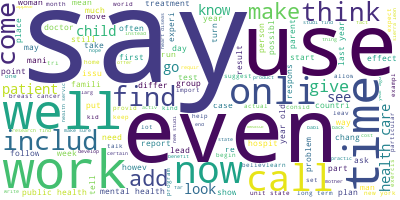

In [6]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [16]:
# Split corpus into TRAIN, TEST, HOLDON
data_train = corpus[:config.TRAIN_SIZE]
TRAIN_SIZE = config.TRAIN_SIZE +1
TEST_SIZE = config.TEST_SIZE + config.TRAIN_SIZE
data_test = corpus[TRAIN_SIZE:TEST_SIZE]
TEST_SIZE = TEST_SIZE + 1
data_holdon = corpus[TEST_SIZE:]

In [7]:
# Create the Document-Word matrix
vectorizer = CountVectorizer(ngram_range = GRAMMAGE,                  
                             analyzer='word',                  # Bi-grams
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=M_STOP_WORDS,            # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(corpus)

In [8]:
# 8. Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.16637774938826771 %


In [9]:
# Build LDA Model
lda_model = LDA(n_topics=E_TOPICS,       # Number of topics
              max_iter=10,               # Max learning iterations
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every = -1,       # compute perplexity every n iters, default: Don't
              n_jobs = -1,               # Use all available CPUs
             )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=6, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [9]:
# 10
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -94445229.49973118
Perplexity:  11538.020977827191
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 6,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [10]:
## GridSearchCV
# Define Search Param
search_params = {'n_components': N_COMPONENTS, 'learning_decay': LEARNING_DECAY}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [6, 10, 15, 20, 25, 30, 50], 'learning_decay': ['.3', '.5', '.7', '.9']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': '.7', 'n_components': 30}
Best Log Likelihood Score:  -32118886.433915168
Model Perplexity:  8431.056962686318


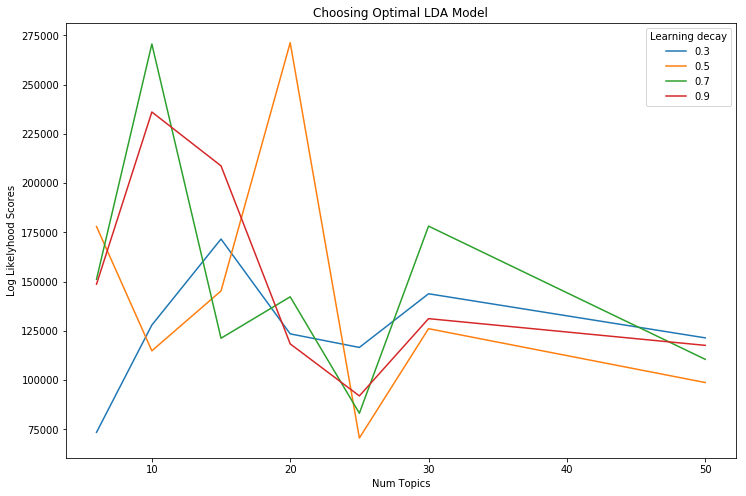

In [14]:
# Get Log Likelyhoods from Grid Search Output
n_topics = search_params['n_components']
learning_decay = LEARNING_DECAY
one_third = len(n_topics)
two_third = one_third*2
three_fourth = one_third*3

gscore = dict(model.cv_results_)
log_likelyhoods_3 = gscore['std_train_score'][0:one_third]
log_likelyhoods_5 = gscore['std_train_score'][one_third:two_third]
log_likelyhoods_7 = gscore['std_train_score'][two_third:three_fourth]
log_likelyhoods_9 = gscore['std_train_score'][three_fourth:]


# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


### 1. Saving Model to disk

In [2]:
# Have: best_lda_model


## ----------------------------------------------------------
## ----------------------------------------------------------
## Pickle
## ----------------------------------------------------------
pickle.dump(best_lda_model,open(dest_model_file_a,'wb'))

## Joblib
## ----------------------------------------------------------
joblib.dump(best_lda_model, dest_model_file_b)

## Dill
## ----------------------------------------------------------
dill.dump(best_lda_model, open(dest_model_file_c,'wb'))

## Vectorizer
## ----------------------------------------------------------
dill.dump(vectorizer, open(dest_vec,'wb'))


## ----------------------------------------------------------
## ----------------------------------------------------------
## Backup GridSearchCV models
## ----------------------------------------------------------
dill.dump(model, open(gs_model_bk,'wb'))

## Best topic
## ----------------------------------------------------------
BEST_TOPICS = model.best_params_['n_components']

NameError: name 'best_lda_model' is not defined

In [10]:
## Vectorizer
## ----------------------------------------------------------
dill.dump(vectorizer, open(dest_vec,'wb'))

In [16]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0,0,0,0,0,0,0,0,0,0.04,0,0,0,0,0.4,0,0,0.53,0,0,0.03,0,0,0,0,0,0,0,0,0,17
Doc1,0,0,0.25,0,0,0,0.1,0,0.38,0,0,0,0.09,0,0,0,0,0,0,0.15,0,0,0,0,0,0,0,0,0,0,8
Doc2,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0.21,0,0,0.02,0,0,0,0,0,0,0,0,0.72,0,0,0,0,25
Doc3,0,0,0,0,0,0,0,0,0.85,0,0,0,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
Doc4,0,0,0.24,0,0,0,0,0,0,0,0.75,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,10
Doc5,0,0,0,0,0,0,0,0,0.96,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0,0,0,8
Doc6,0.95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05,0,0,0,0,0
Doc7,0,0,0,0,0.62,0,0,0,0,0,0,0,0,0,0,0,0.37,0,0,0,0,0,0,0,0,0,0,0,0,0,4
Doc8,0,0,0,0,0.01,0,0,0,0.06,0,0,0,0,0.04,0.84,0,0,0,0,0.04,0.01,0,0,0,0,0,0,0,0,0,14
Doc9,0,0,0,0,0.15,0,0,0,0.03,0,0,0,0,0,0,0.08,0.39,0,0,0,0,0,0,0,0,0.29,0,0,0,0.05,16


In [22]:
df_document_topic.to_csv(dest_df, sep='|')

In [23]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,15,3257
1,13,3132
2,2,2220
3,25,1756
4,8,1662
5,14,1452
6,16,1427
7,17,1420
8,10,1416
9,29,1050


In [26]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Shaynie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
13     -96.211868  -29.434620       1        1  9.347710
15      63.592346  -63.132130       2        1  8.904253
2      -36.143127  -55.794556       3        1  7.624096
8      -10.549674   86.753654       4        1  5.940245
17      43.029167 -109.285286       5        1  5.856600
25      13.139302  -62.595936       6        1  5.571040
14      56.091305   21.752748       7        1  5.480978
16      97.182106  108.310898       8        1  5.420579
10      -5.152155  138.422913       9        1  4.889969
29     114.657219  -64.150856      10        1  4.113932
12     -51.996395   71.254761      11        1  3.572297
7      134.999634   64.650314      12        1  3.512966
9       38.454269  -22.107122      13        1  3.343949
20      36.530022  100.191475      14        1  3.151032
6       -8.398402  -19.186338      15        1  2.901443
19     -77.998680  -81.607094      16        1  2.059213
1       53.039455  146.793564      17        1  2.035443
4     -120.780113   20.369593      18        1  1.647152
18     -17.544613 -106.163673      19        1  1.542448
27     -50.870991   -9.500456      20        1  1.509894
0       70.526459   66.264496      21        1  1.466556
5      -72.472359   29.353676      22        1  1.442718
22     139.311646   -6.764754      23        1  1.274959
21      85.558830  -17.732779      24        1  1.174363
3     -102.238182   79.883690      25        1  1.156064
11      13.389349   15.630431      26        1  1.139744
24     -57.746933  122.663658      27        1  1.087522
26      22.086346   56.484463      28        1  1.085799
28     -24.318756   33.916599      29        1  1.048427
23     101.458580   28.700596      30        1  0.698608, topic_info=       Category          Freq           Term         Total  loglift  logprob
term                                                                        
18360   Default  17972.000000         cancer  17972.000000  30.0000  30.0000
167900  Default  19853.000000          woman  19853.000000  29.0000  29.0000
23844   Default  20709.000000          child  20709.000000  28.0000  28.0000
108772  Default  39635.000000        patient  39635.000000  27.0000  27.0000
147365  Default  32678.000000          studi  32678.000000  26.0000  26.0000
57003   Default  16589.000000           food  16589.000000  25.0000  25.0000
129260  Default  31593.000000       research  31593.000000  24.0000  24.0000
19173   Default  28407.000000           care  28407.000000  23.0000  23.0000
69803   Default  22718.000000         hospit  22718.000000  22.0000  22.0000
64987   Default  53150.000000         health  53150.000000  21.0000  21.0000
161652  Default   9489.000000         vaccin   9489.000000  20.0000  20.0000
163247  Default  10028.000000          virus  10028.000000  19.0000  19.0000
45658   Default  11999.000000            eat  11999.000000  18.0000  18.0000
100690  Default  10483.000000            nhs  10483.000000  17.0000  17.0000
107853  Default   8005.000000         parent   8005.000000  16.0000  16.0000
166458  Default   9158.000000         weight   9158.000000  15.0000  15.0000
44555   Default  17763.000000           drug  17763.000000  14.0000  14.0000
50612   Default   7356.000000        exercis   7356.000000  13.0000  13.0000
15768   Default   9582.000000          brain   9582.000000  12.0000  12.0000
10765   Default   6364.000000           babi   6364.000000  11.0000  11.0000
21597   Default   6501.000000           cell   6501.000000  10.0000  10.0000
16241   Default   4845.000000         breast   4845.000000   9.0000   9.0000
75110   Default  10875.000000         infect  10875.000000   8.0000   8.0000
141061  Default   5502.000000          smoke   5502.000000   7.0000   7.0000
137070  Default  12282.000000         servic  12282.000000   6.0000   6.0000
102569  Default   7867.000000           nurs   7867.00

In [19]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aafter,aall,aalmost,aan,aand,aani,aanyth,aap,aap committe,...,zucchini lemon,zucchini onion,zucchini red,zucchini round,zucchini salt,zucchini veggi,zucker,zuckerman,zumba,zumba class
Topic0,0.050000,0.05,2.956316,0.05,0.358883,0.050000,0.050000,0.050000,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05
Topic1,0.050000,0.05,0.050000,0.05,0.050000,0.050000,0.050000,3.094907,0.05,0.05,...,11.05,11.05,14.05,20.05,13.05,12.05,0.05,0.05,0.050000,0.05
Topic2,0.541264,0.05,0.050000,0.05,2.881438,17.122900,3.805763,0.050000,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,51.857344,22.05
Topic3,0.050000,0.05,0.050000,0.05,0.050000,0.050000,0.050000,0.050000,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05
Topic4,0.050000,0.05,0.050000,0.05,0.050000,1.371645,0.050000,0.050000,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05


In [20]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,cancer,woman,breast,test,breast cancer,screen,year,patient,treatment,risk,research,new,studi,lung,prostat
Topic 1,fat,calori,food,eat,sugar,make,oil,healthi,protein,add,fruit,serv,salt,gram,low
Topic 2,weight,exercis,bodi,eat,sleep,time,day,food,peopl,make,diet,run,help,studi,activ
Topic 3,health,insur,care,plan,state,peopl,coverag,law,year,cost,health insur,pay,feder,exchang,afford
Topic 4,drink,alcohol,studi,peopl,research,health,disord,skin,medic,problem,eat,risk,effect,patient,adult
Topic 5,nhs,care,servic,patient,need,peopl,health,social,make,healthcar,chang,organis,year,local,improv
Topic 6,studi,research,diseas,peopl,risk,heart,blood,effect,high,year,caus,new,health,trial,patient
Topic 7,patient,health,nurs,hospit,need,care,peopl,make,time,sexual,mental,think,duncan,support,feel
Topic 8,woman,health,child,studi,research,year,age,high,report,risk,rate,peopl,percent,babi,obes
Topic 9,peopl,year,just,make,time,think,know,want,feel,life,come,day,help,thing,tell


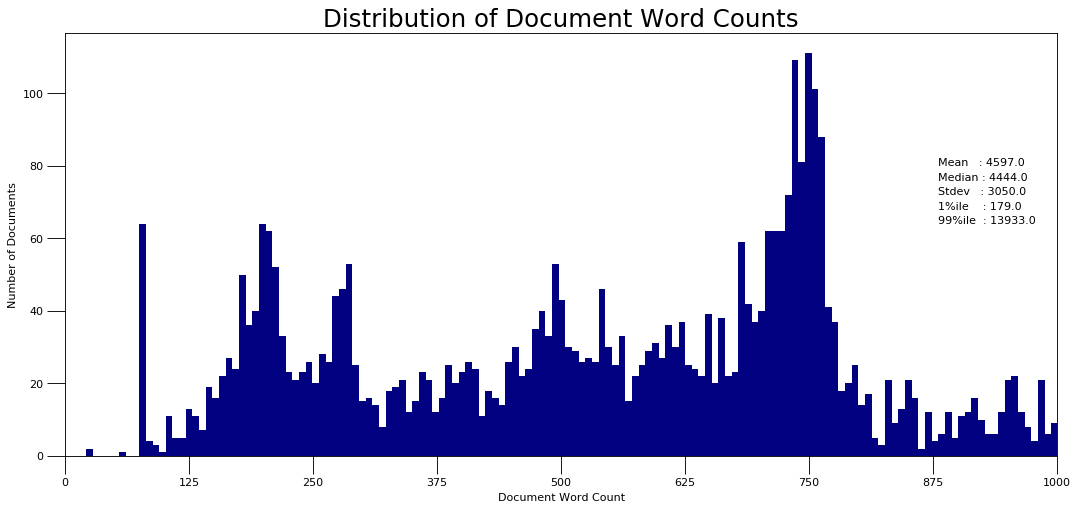

In [21]:
doc_lens = [len(d) for d in frame['list_text'].values]

# Plot
plt.figure(figsize=(16,7), dpi=80)
plt.hist(doc_lens, bins = 10000, color='navy')
plt.text(880, 80, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(880, 76, "Median : " + str(round(np.median(doc_lens))))
plt.text(880, 72, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(880, 68, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(880, 64, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [22]:
unseem_data = '''
Ultra-processed foods - such as chicken nuggets, ice cream and breakfast cereals - have been linked to early death and poor health, scientists say. 
Researchers in France and Spain say the amount of such food being eaten has soared.
Their studies are not definite proof of harm but do come hot on the heels of trials suggesting ultra-processed foods 
.
Experts expressed caution but called for further investigation. 
The term comes from a way of classifying food by how much industrial processing it has been through.
The lowest category is "unprocessed or minimally processed foods", which include: • fruit • vegetables • milk • meat • legumes such as lentils • seeds • grains such as rice • eggs
"Processed foods" have been altered to make them last longer or taste better - generally using salt, oil, sugar or fermentation.
This category includes: • cheese • bacon • home-made bread • tinned fruit and vegetables • smoked fish • beer
Then come "ultra-processed foods", which have been through more substantial industrial processing and often have long ingredient lists on the packet, including added preservatives, sweeteners or colour enhancers. 
If a product contains more than five ingredients, it is probably ultra-processed, says Prof Maira Bes-Rastrollo, of the University of Navarra, citing a maxim.
Examples include: • processed meat such as sausages and hamburgers • breakfast cereals or cereal bars • instant soups • sugary fizzy drinks • chicken nuggets • cake • chocolate • ice cream • mass-produced bread • many "ready to heat" meals such as pies and pizza | meal-replacement shakes 
, by the University of Navarra, in Spain, followed 19,899 people for a decade and assessed their diet every other year. There were 335 deaths during the study.
But for every 10 deaths among those eating the least ultra-processed food, there were 16 deaths among those eating the most (more than four portions a day).
, by the University of Paris, followed 105,159 people for five years and assessed their diet twice a year.
It showed those eating more ultra-processed food had worse heart health. 
Rates of cardiovascular disease were 277 per 100,000 people per year among those eating the most ultra-processed food, compared with 242 per 100,000 among those eating the least. 
The rapid increase of ultra-processed foods over less processed foods, "may drive a substantial burden of cardiovascular diseases in the next decades," said Dr Mathilde Touvier, of the University of Paris.
"[The] evidence is accumulating," said Dr Touvier, noting "increasing numbers of independent studies". Prof Bes-Rastrollo said she was "very certain" ultra-processed foods were bad for health.
Last year, a link was made with 
.
The challenge is being 100% sure. The studies have spotted a pattern between highly processed food and poor health but they cannot prove that one causes the other. 
Those who ate the most ultra-processed food were also more likely to have other unhealthy behaviours, such as smoking, which the researchers tried to account for. 
But there's no guarantee everything relevant was covered, says Kevin McConway, a professor of statistics at The Open University.
"These studies do increase my confidence that there's something real behind these associations - but I'm still far from sure."
The first trial of ultra-processed foods showed they led people to eat more and put on weight. 
Researchers at the US National Institutes of Health monitored every morsel of food that volunteers ate for a month.
And when given ultra-processed food, they ate 500 calories a day more than when they were given unprocessed meals.
Other suggestions include: 
These ideas still need researching.
While the term ultra-processed food may be new, the health advice will be very familiar: adopt a Mediterranean-style diet.
Such a diet includes plenty of minimally or unprocessed foods, such as fruit, vegetables, fish, nuts and seeds, beans, lentils and wholegrains, said Victoria Taylor, senior dietician at the British Heart Foundation.
"This, along with exercising regularly and not smoking, has been shown to be beneficial for lowering risk of heart and circulatory disease."
Measures such as taxation and marketing restrictions on ultra-processed foods, should be considered, said Prof Bes-Rastrollo, given the weight of evidence. 
There are certainly a lot of critics. 
The labelling of food as ultra-processed could be inconsistent, said Dr Gunter Kuhnle, an expert in nutrition and health at the University of Reading
"It is also not obvious why salami is considered to be ultra-processed, yet cheese, which often requires considerably more processing steps and additives, is not.  The classification combines a wide range of foods with very different potential impacts on health, which limits its usefulness as a basis for recommendations."
The studies were published in the British Medical Journal.
'''

In [25]:
# Define function to predict topic for a given text document.

# Predict the topic
# for text in data_test:
#     topic, prob_scores = predict_topic(text = text)
#     print(topic)
topic, prob_scores = predict_topic(unseem_data)
print(topic)
pprint(prob_scores)

[[9.14076796e-05 2.75786642e-01 2.33416912e-01 9.14076807e-05
  9.40026077e-03 9.14076795e-05 2.59882298e-01 9.14076794e-05
  7.55982664e-02 9.14076799e-05 9.14076799e-05 1.49286782e-02
  9.14076793e-05 9.14076791e-05 1.15082826e-01 9.14076807e-05
  9.14076810e-05 1.48072237e-02 9.14076797e-05 9.14076807e-05]] 1
['fat', 'calori', 'food', 'eat', 'sugar', 'make', 'oil', 'healthi', 'protein', 'add', 'fruit', 'serv', 'salt', 'gram', 'low']
array([[9.14076796e-05, 2.75786642e-01, 2.33416912e-01, 9.14076807e-05,
        9.40026077e-03, 9.14076795e-05, 2.59882298e-01, 9.14076794e-05,
        7.55982664e-02, 9.14076799e-05, 9.14076799e-05, 1.49286782e-02,
        9.14076793e-05, 9.14076791e-05, 1.15082826e-01, 9.14076807e-05,
        9.14076810e-05, 1.48072237e-02, 9.14076797e-05, 9.14076807e-05]])


### Fitting with KMeans

Component's weights: 
 [[ 0.07  0.09  0.27  0.12  0.04  0.03  0.16  0.03  0.27  0.62  0.2   0.31
   0.03  0.07  0.1   0.08  0.13  0.05  0.44  0.2 ]
 [-0.02 -0.07 -0.24 -0.06 -0.02 -0.01 -0.01  0.01 -0.05 -0.36 -0.11 -0.11
   0.    0.02 -0.01 -0.01 -0.04 -0.03  0.88 -0.03]]
Perc of Variance Explained: 
 [0.03 0.13]


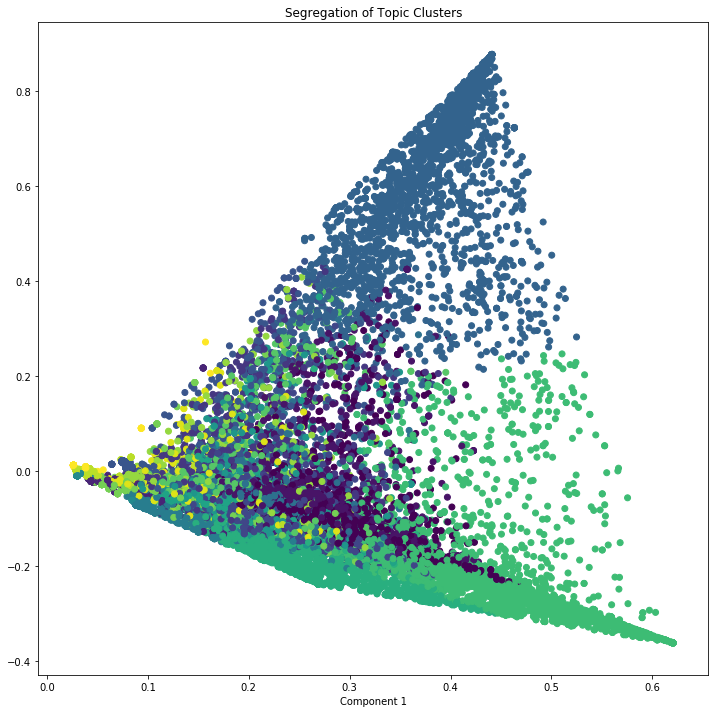

In [27]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=BEST_TOPICS, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plotting clusters
plotting_clusters(x, y, clusters)

In [28]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = corpus, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [29]:
# Get similar documents
doc_ids, docs = similar_documents(text=unseem_data, doc_topic_probs=lda_output, documents = corpus, top_n=1, verbose=True)
print('\n', docs[0][:500])

[[9.14076796e-05 2.75786642e-01 2.33416912e-01 9.14076807e-05
  9.40026077e-03 9.14076795e-05 2.59882298e-01 9.14076794e-05
  7.55982664e-02 9.14076799e-05 9.14076799e-05 1.49286782e-02
  9.14076793e-05 9.14076791e-05 1.15082826e-01 9.14076807e-05
  9.14076810e-05 1.48072237e-02 9.14076797e-05 9.14076807e-05]] 1
Topic KeyWords:  ['fat', 'calori', 'food', 'eat', 'sugar', 'make', 'oil', 'healthi', 'protein', 'add', 'fruit', 'serv', 'salt', 'gram', 'low']
Topic Prob Scores of text:  [[0.  0.3 0.2 0.  0.  0.  0.3 0.  0.1 0.  0.  0.  0.  0.  0.1 0.  0.  0.
  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.3 0.2 0.  0.  0.  0.3 0.  0.1 0.  0.  0.  0.  0.  0.1 0.  0.  0.
  0.  0. ]]

 say cinnamon say sugar popular combin cours re interest health promot effect cinnamon may want think anew spice instanc say execut chef bourbon steak restaur washington whi not add savori dish use cinnamon creat spice herb rub lamb loin also whip great spinach salad raisin pine nut cinnamon critchley be fan intens

### Fitting with DBSCAN

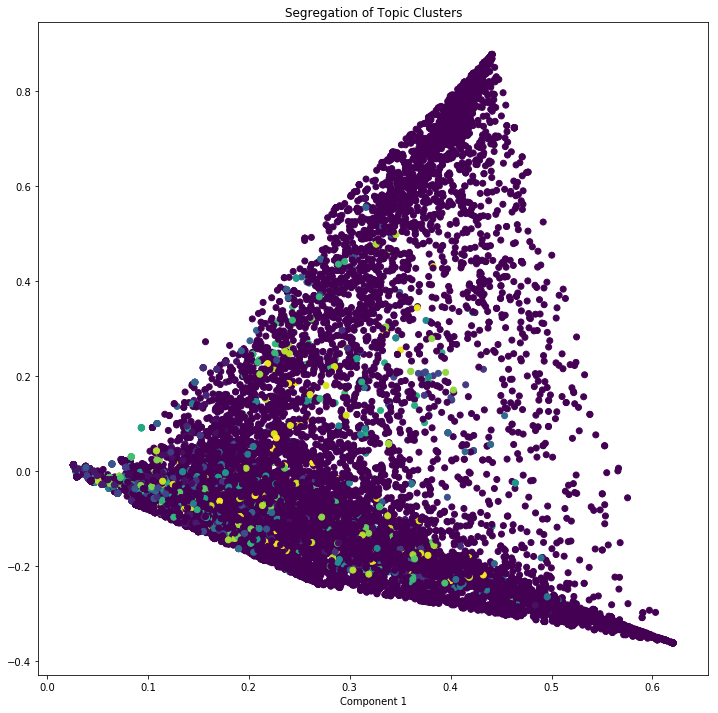

In [30]:
# Construct the DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X = ss.fit_transform(lda_output)

dbscan_clusters = DBSCAN(eps=0.123, min_samples = 4).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plotting clusters
plotting_clusters(x, y, dbscan_clusters)